In [42]:
##### Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

# To avoid warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
##### Import data

#X-axis accelerometry
dfx = pd.read_csv('accs_x.csv', names=['id_','time_ref','value_acc_x'], header=0)

#Y-axis accelerometry
dfy = pd.read_csv('accs_y.csv', names=['id_','time_ref','value_acc_y'], header=0)

#Z-axis accelerometry
dfz = pd.read_csv('accs_z.csv', names=['id_','time_ref','value_acc_z'], header=0)

#energy data associated with accelerometry and heart rate per time interval
df_energy = pd.read_csv('energy.csv')

In [6]:
#Datasets info


# dfx
print(f' acc_x '.center(50,'#'))
print(dfx.info())
print(dfx.describe())
print(' ')

# dfy
print(f' acc_y '.center(50,'#'))
print(dfy.info())
print(dfy.describe())
print(' ')

# dfz
print(f' acc_z '.center(50,'#'))
print(dfz.info())
print(dfz.describe())
print(' ')

# df_energy
print(f' energy '.center(50,'#'))
print(df_energy.info())
print(df_energy.describe())
print(' ')

##################### acc_x ######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id_          1459482 non-null  int64  
 1   time_ref     1459482 non-null  object 
 2   value_acc_x  1459482 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.4+ MB
None
                id_   value_acc_x
count  1.459482e+06  1.459482e+06
mean   7.005000e+02  2.818822e-02
std    4.047226e+02  5.459730e-01
min    0.000000e+00 -3.748779e+00
25%    3.500000e+02 -2.980957e-01
50%    7.005000e+02 -2.484131e-02
75%    1.051000e+03  4.101562e-01
max    1.401000e+03  8.987549e+00
 
##################### acc_y ######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------  

## Preprocessing data

We create the variable 'jerk', which is the derivative of the acceleration. To do it, we approximate it using the variable as discrete and assuming that the intervals of time are constant. 
The acceleration is a vector, therefore its derivative has vectorial character as well. Then, we calculate the partial derivatives respect to each axis.

In [16]:
dfy

,id_,time_ref,value_acc_y
0,0,accy_minus_0000,0.300049
1,0,accy_minus_0001,0.297119
2,0,accy_minus_0002,0.309814
3,0,accy_minus_0003,0.322021
4,0,accy_minus_0004,0.277344
...,...,...,...
1459477,1401,accy_minus_1036,-0.009521
1459478,1401,accy_minus_1037,-0.017090
1459479,1401,accy_minus_1038,-0.018066
1459480,1401,accy_minus_1039,0.009521


In [46]:
dfx['jerk_x']=dfx['value_acc_x']-dfx.groupby('id_')['value_acc_x'].shift(-1)
dfy['jerk_y']=dfy['value_acc_y']-dfy.groupby('id_')['value_acc_y'].shift(-1)
dfz['jerk_z']=dfz['value_acc_z']-dfz.groupby('id_')['value_acc_z'].shift(-1)

In [47]:
#Removing missing values created
dfx.dropna(inplace=True)
dfy.dropna(inplace=True)
dfz.dropna(inplace=True)

In [48]:
##### Merge the three axes

dfx.time_ref=dfx.time_ref.apply(lambda x: x[x.rfind("_")+1:])
dfy.time_ref = dfy.time_ref.apply(lambda x: x[x.rfind("_")+1:])
dfz.time_ref = dfx.time_ref.apply(lambda x: x[x.rfind("_")+1:])

df_acc= pd.merge(pd.merge(dfx,dfy,how="inner",on=['id_', 'time_ref']),dfz,how="inner",on=['id_', 'time_ref'])


Creatation of the acceleration module and jerk module variables, which are scalar magnitudes with crucial information about the activity and I assumed that are relevant to the model.

In [49]:
df_acc["mod_acc"] = np.sqrt((df_acc.value_acc_x**2) + (df_acc.value_acc_y**2) + (df_acc.value_acc_z**2))
df_acc["mod_jerk"] = np.sqrt((df_acc.jerk_x**2) + (df_acc.jerk_y**2) + (df_acc.jerk_z**2))


In [50]:
df_acc

,id_,time_ref,value_acc_x,jerk_x,value_acc_y,jerk_y,value_acc_z,jerk_z,mod_acc,mod_jerk
0,0,0000,-0.837891,0.012695,0.300049,0.002930,-0.437500,0.010742,0.991714,0.016886
1,0,0001,-0.850586,-0.015137,0.297119,-0.012695,-0.448242,0.002686,1.006329,0.019937
2,0,0002,-0.835449,0.004395,0.309814,-0.012207,-0.450928,-0.008545,0.998647,0.015535
3,0,0003,-0.839844,0.002441,0.322021,0.044678,-0.442383,-0.023438,1.002366,0.050511
4,0,0004,-0.842285,0.002441,0.277344,-0.007324,-0.418945,0.016113,0.980754,0.017867
...,...,...,...,...,...,...,...,...,...,...
1458075,1401,1035,0.022705,0.032227,0.022705,0.032227,0.022705,0.032227,0.039326,0.055818
1458076,1401,1036,-0.009521,0.007568,-0.009521,0.007568,-0.009521,0.007568,0.016492,0.013109
1458077,1401,1037,-0.017090,0.000977,-0.017090,0.000977,-0.017090,0.000977,0.029600,0.001691
1458078,1401,1038,-0.018066,-0.027588,-0.018066,-0.027588,-0.018066,-0.027588,0.031292,0.047784


## Data visualization


<AxesSubplot:xlabel='time_ref', ylabel='value_acc_x'>

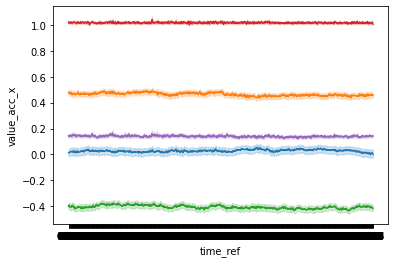

In [40]:
# Let's see some time series and distributions of the variables

sns.lineplot("time_ref","value_acc_x",data=df_acc)
sns.lineplot("time_ref","value_acc_y",data=df_acc)
sns.lineplot("time_ref","value_acc_z",data=df_acc)
sns.lineplot("time_ref","mod_acc",data=df_acc)
sns.lineplot("time_ref","mod_jerk",data=df_acc)


In [ ]:
##### X,y,z accelerometry over time
#I choose 15 random ids

random_id = df_acc.loc[sample(range(0,len(df_acc.id_)),15)].id_.values
data = df_acc[df_acc.id_.isin(random_id)]

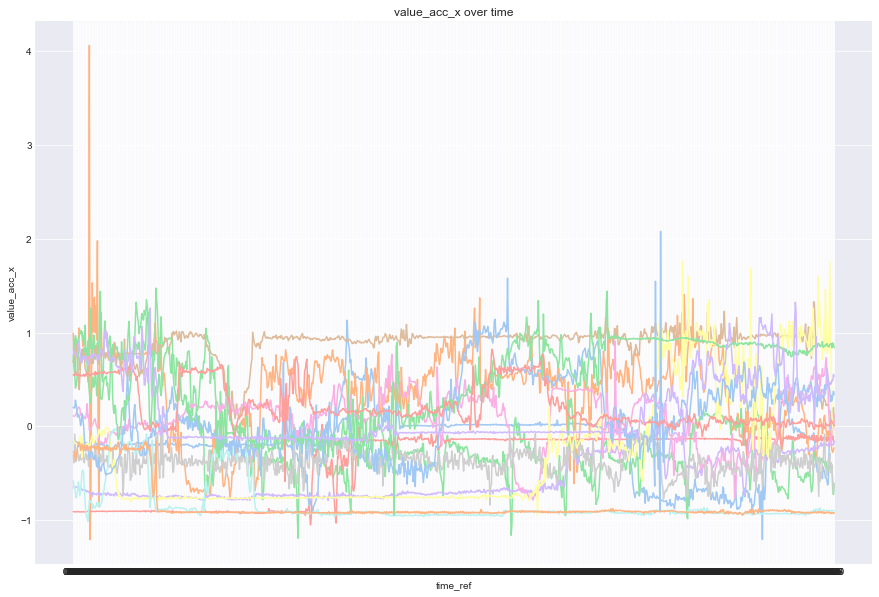

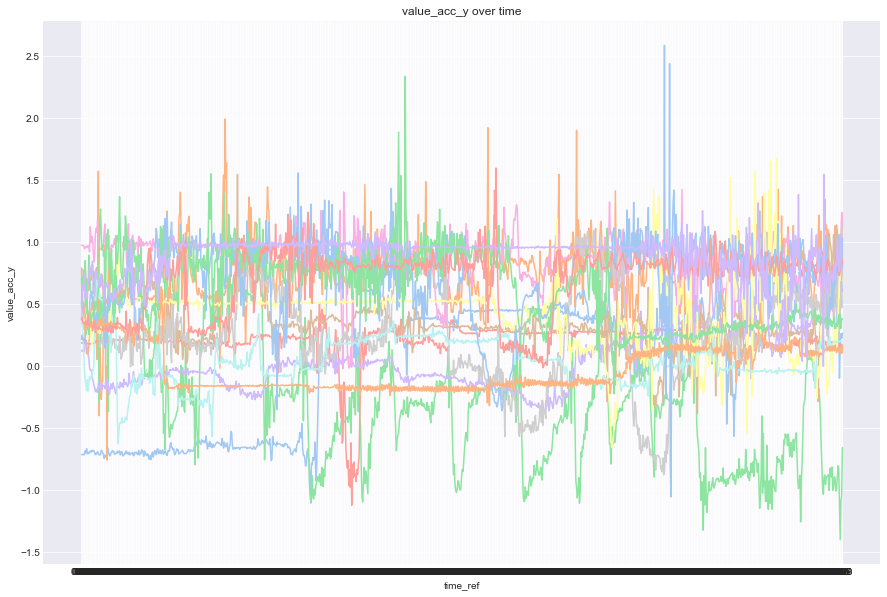

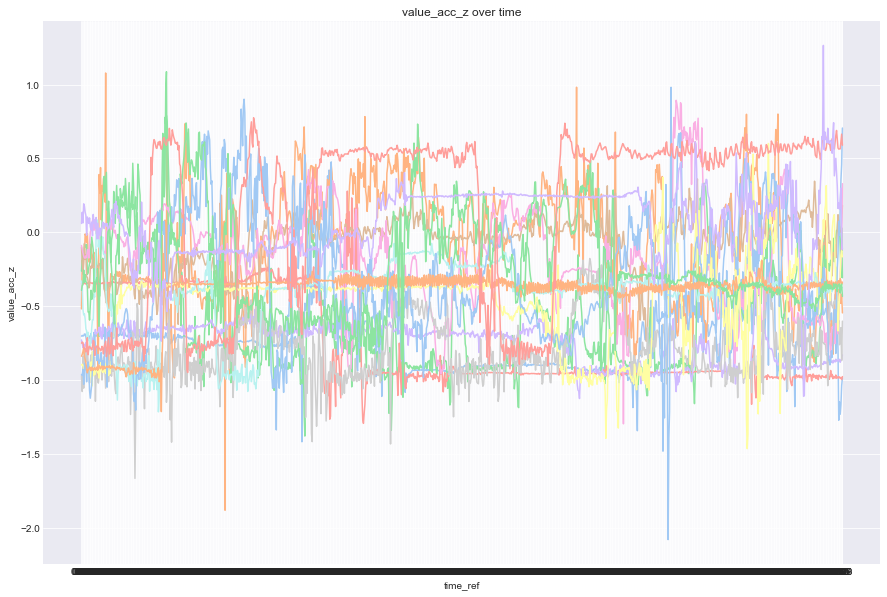

In [62]:
for feat in ['value_acc_x', 'value_acc_y', 'value_acc_z']:
    plt.figure(figsize=(15, 10))
    sns.lineplot('time_ref', feat, data = data, hue = 'id_', legend=False, palette='pastel')
    plt.tick_params(bottom = False)
    plt.title(f'{feat} over time')
    plt.show()

In [57]:
##### Acceleration module and jerk module variables over time
#I choose 15 random ids

random_id = df_acc.loc[sample(range(0,len(df_acc.id_)),15)].id_.values
data = df_acc[df_acc.id_.isin(random_id)]

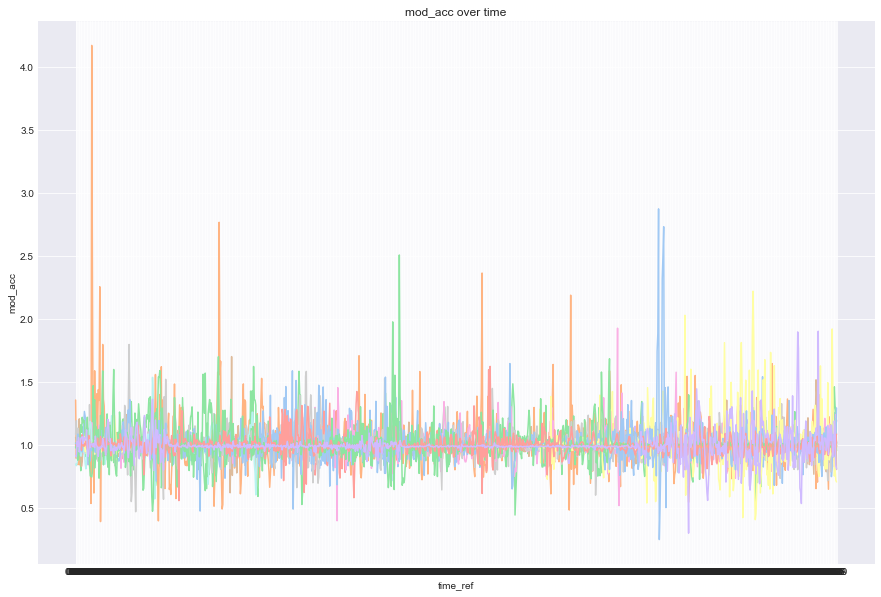

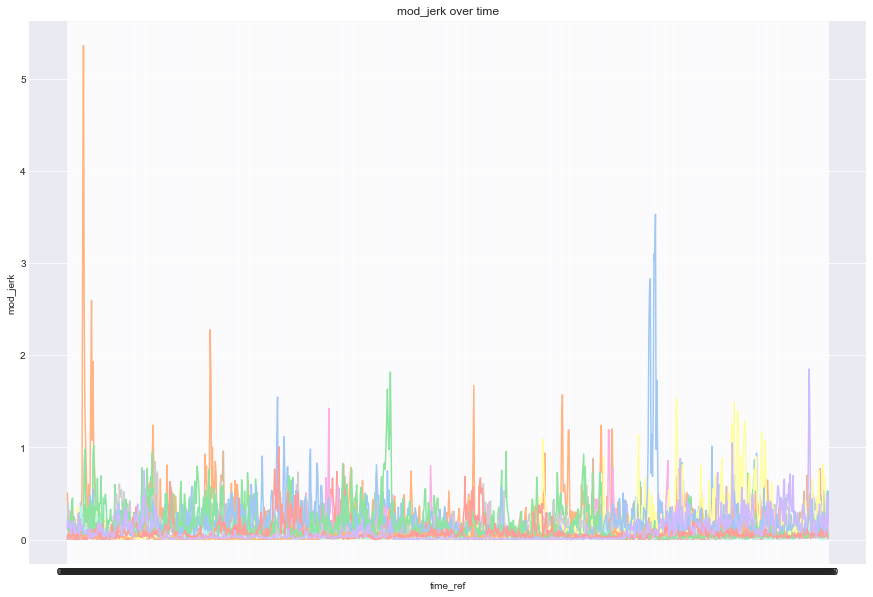

In [63]:
for feat in ['mod_acc', 'mod_jerk']:
    plt.figure(figsize=(15, 10))
    sns.lineplot('time_ref', feat, data = data, hue = 'id_', legend=False, palette='pastel')
    plt.tick_params(bottom = False)
    plt.title(f'{feat} over time')
    plt.show()

## Outliers
I analyze the histograms of the key variables to locate possible failures in data collection. See that there are extreme values but a priori we cannot delete them since we cannot conclude with this data that they are errors in the measurement. We must be careful with them, because they can affect both the scoring and the model itself.

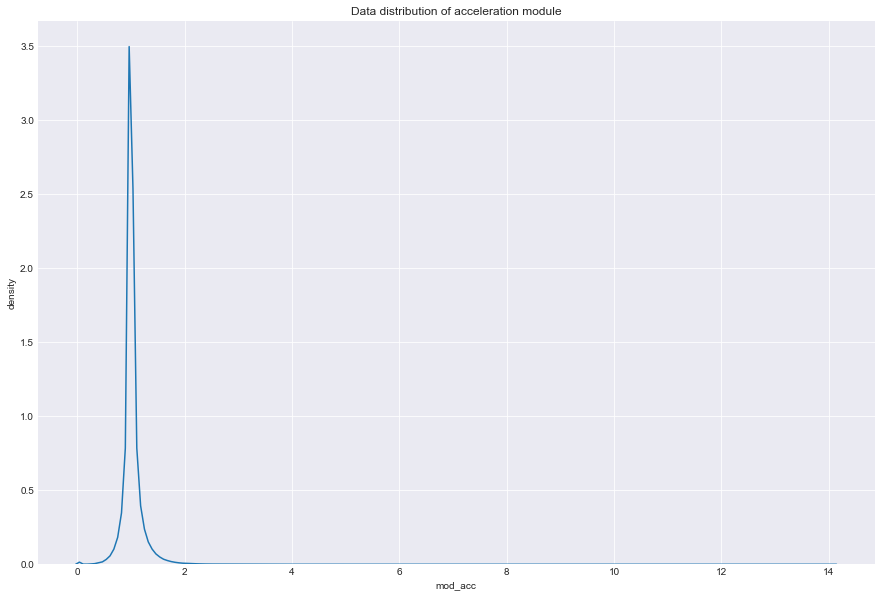

In [64]:
plt.figure(figsize=(15, 10))
sns.kdeplot(df_acc.mod_acc)
plt.xlabel("mod_acc")
plt.ylabel("density")
plt.title('Data distribution of acceleration module')
plt.show()

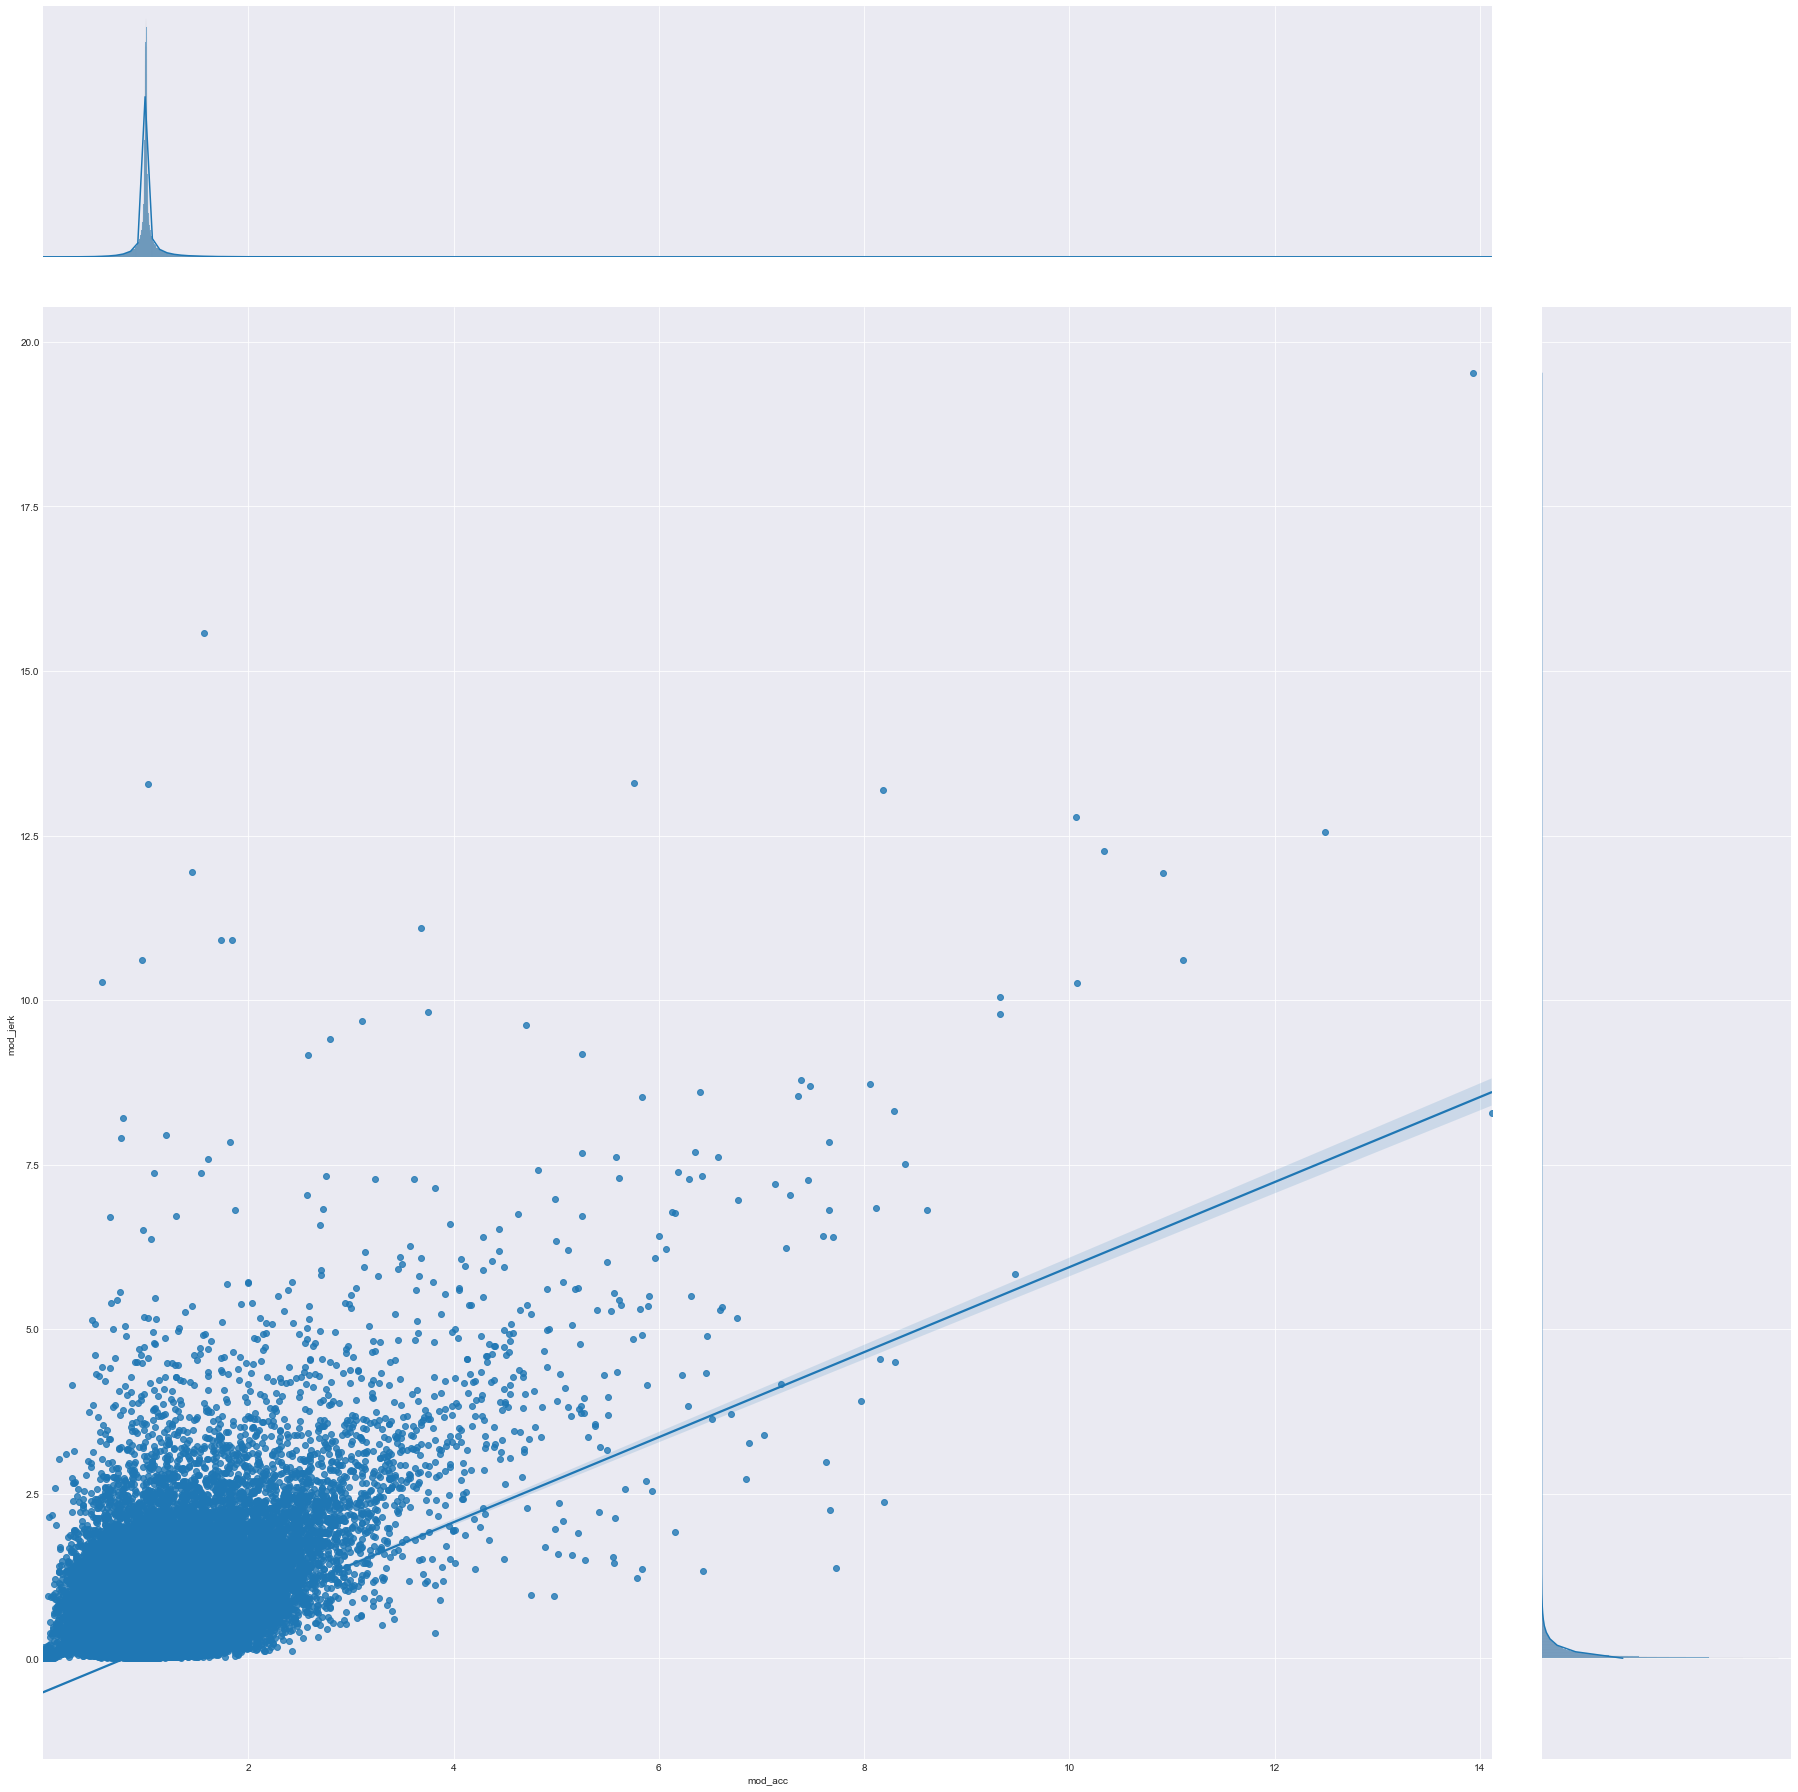

In [66]:
##### Relationship between acceleration module and jerk module
sns.jointplot(x = 'mod_acc', y = 'mod_jerk', data = df_acc, kind = 'reg',  height = 25)


In [67]:
df_energy.columns

Index(['date_Hr', 'value_Hr', 'startDate_energy', 'endDate_energy',
       'totalTime_energy', 'value_energy', 'id_'],
      dtype='object')

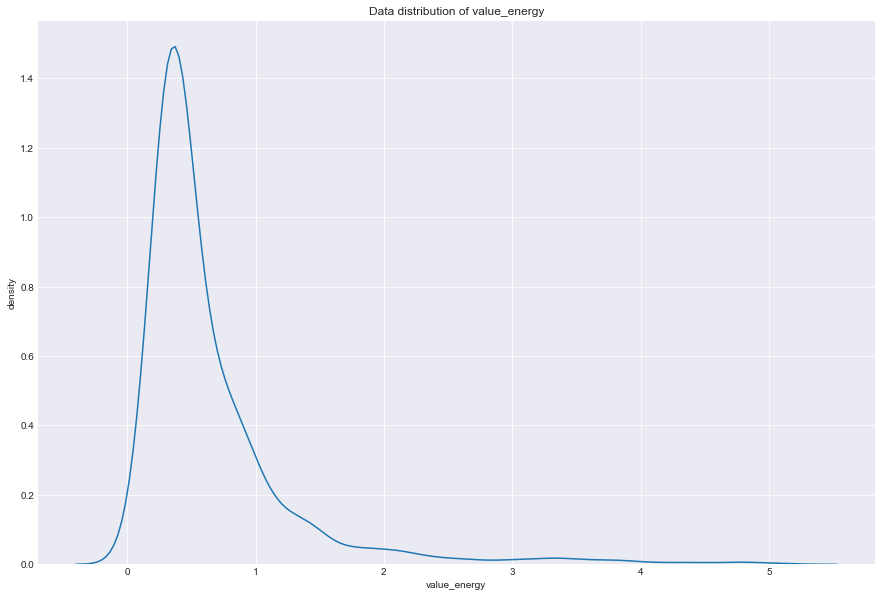

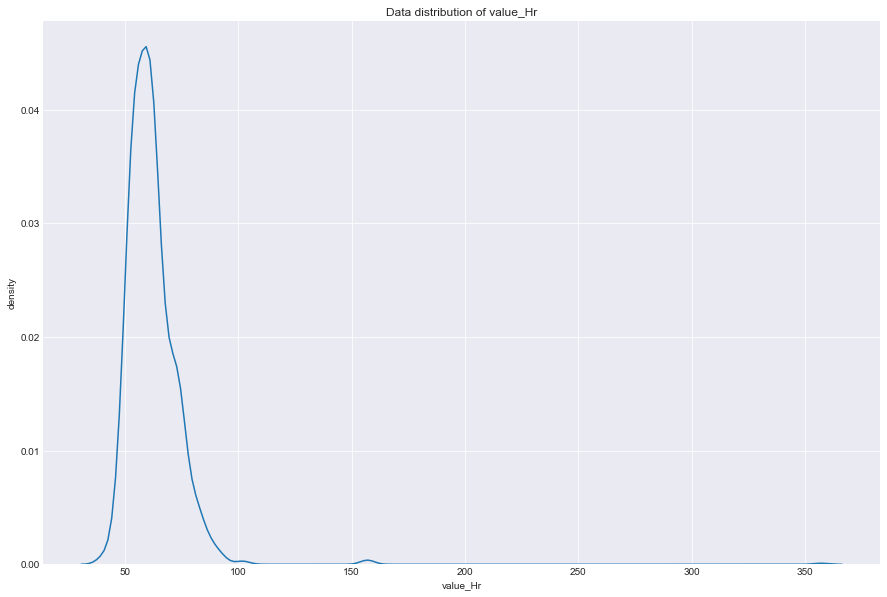

In [70]:
# Let's see the distribution of energy data associated 
# with accelerometry and heart rate per time interval

for feat in ['value_energy','value_Hr']:

    plt.figure(figsize=(15, 10))
    sns.kdeplot(df_energy[feat])
    plt.xlabel(f"{feat}")
    plt.ylabel("density")
    plt.title(f'Data distribution of {feat}')
    plt.show()

## Features Engineering

I differentiate between two sets of variables: 
   
-First, I want to collect as much information as possible about the distribution of acceleration and jerk per invidual (mean, st, median...).

-Second, I'll look for working in the system of frequencies and moments by transformations. It's understood that, due to the nature of the problem, this transformation can help to extract more information from the physical activity. We take only one observation per id in order to train the model with the energy data.


In [72]:
# Percentile function for agregate
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [73]:
df_acc_agg = df_acc.groupby("id_").agg({'mod_acc': [np.sum, percentile(25), percentile(75), np.mean, np.median],
                                        'mod_jerk':[np.sum, percentile(25), percentile(75), np.mean, np.median ]}).reset_index()
df_acc_agg.columns = ['_'.join(col).strip() for col in df_acc_agg.columns.values]   
df_acc_agg.rename(columns={"id__":"id_"},inplace=True)
df_acc_agg

,id_,mod_acc_sum,mod_acc_percentile_25,mod_acc_percentile_75,mod_acc_mean,mod_acc_median,mod_jerk_sum,mod_jerk_percentile_25,mod_jerk_percentile_75,mod_jerk_mean,mod_jerk_median
0,0,1043.220073,0.995411,1.009186,1.003096,1.004628,32.751422,0.008332,0.036585,0.031492,0.018499
1,1,1062.119013,0.995555,1.037425,1.021268,1.008131,148.592177,0.025989,0.186147,0.142877,0.082003
2,2,1047.105327,0.995010,1.007831,1.006832,1.000783,80.642615,0.014164,0.062698,0.077541,0.026917
3,3,1043.340073,0.994491,1.008151,1.003212,1.004660,28.341771,0.004286,0.020944,0.027252,0.009040
4,4,1050.852598,1.006196,1.011126,1.010435,1.009513,47.547551,0.004569,0.026014,0.045719,0.008492
...,...,...,...,...,...,...,...,...,...,...,...
1397,1397,1050.242694,0.995207,1.010991,1.009849,0.997482,126.172786,0.002457,0.154333,0.121320,0.036943
1398,1398,1029.323949,0.987261,0.991333,0.989735,0.989282,18.639718,0.004012,0.010716,0.017923,0.006141
1399,1399,1041.983537,0.997301,1.003573,1.001907,1.000854,31.715524,0.005222,0.018557,0.030496,0.008402
1400,1400,1037.054811,0.992046,0.999743,0.997168,0.995710,32.293950,0.006720,0.026404,0.031052,0.011644


In [74]:
##### Merge of both datasets and save for modelling notebook

df_final = pd.merge(df_acc_agg, df_energy, how="inner", on="id_")
df_final.to_csv('energy_data.csv', index = False)
print('Done')

Done
